# Set up

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchio as tio
from torch.utils.data import DataLoader, Dataset

# Load data

In [2]:
train_data = pd.read_pickle('data/lung_cancer_train.pkl')
test_data = pd.read_pickle('data/lung_cancer_test.pkl')

train_data.head()

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."


# Preprocess

In [11]:
class LungRADSDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data['hu_array'])

    def __getitem__(self, idx):
        img = self.data['hu_array'].iloc[idx]
        mask = self.data['mask'].iloc[idx]

        # Add x and channel dimensions for grayscale images
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        if self.transform:
            img = self.transform(img)

        return img.squeeze(1), mask.squeeze(1) # (1, H, W)

In [12]:
# Transform pipeline
transform = tio.Compose([
    tio.RescaleIntensity(percentiles=(0, 99)),  # Percentile stretching
    # tio.ZNormalization(),                       # Standardization
])

# def create_subjects(data):
#     subjects = []
#     for idx, row in data.iterrows():
#         img = np.array(row['hu_array'])
#         mask = np.array(row['mask'])
#         subject = tio.Subject({
#             'img': tio.ScalarImage(tensor=img.reshape(1, 1, *img.shape)),
#             'mask': tio.LabelMap(tensor=mask.reshape(1, 1, *mask.shape))
#         })
#         subjects.append(subject)
#     return subjects

# train_subjects = create_subjects(train_data)
# test_subjects = create_subjects(test_data)

# train_dataset = tio.SubjectsDataset(train_subjects, transform=transform)
# test_dataset = tio.SubjectsDataset(test_subjects, transform=transform)

train_dataset = LungRADSDataset(train_data, transform=transform)
test_dataset = LungRADSDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

for img, mask in train_loader:
    print(f'Image shape: {img.shape}, Mask shape: {mask.shape}')  # (B, C, H, W)
    break

Image shape: torch.Size([16, 1, 512, 512]), Mask shape: torch.Size([16, 1, 512, 512])


# Visualize

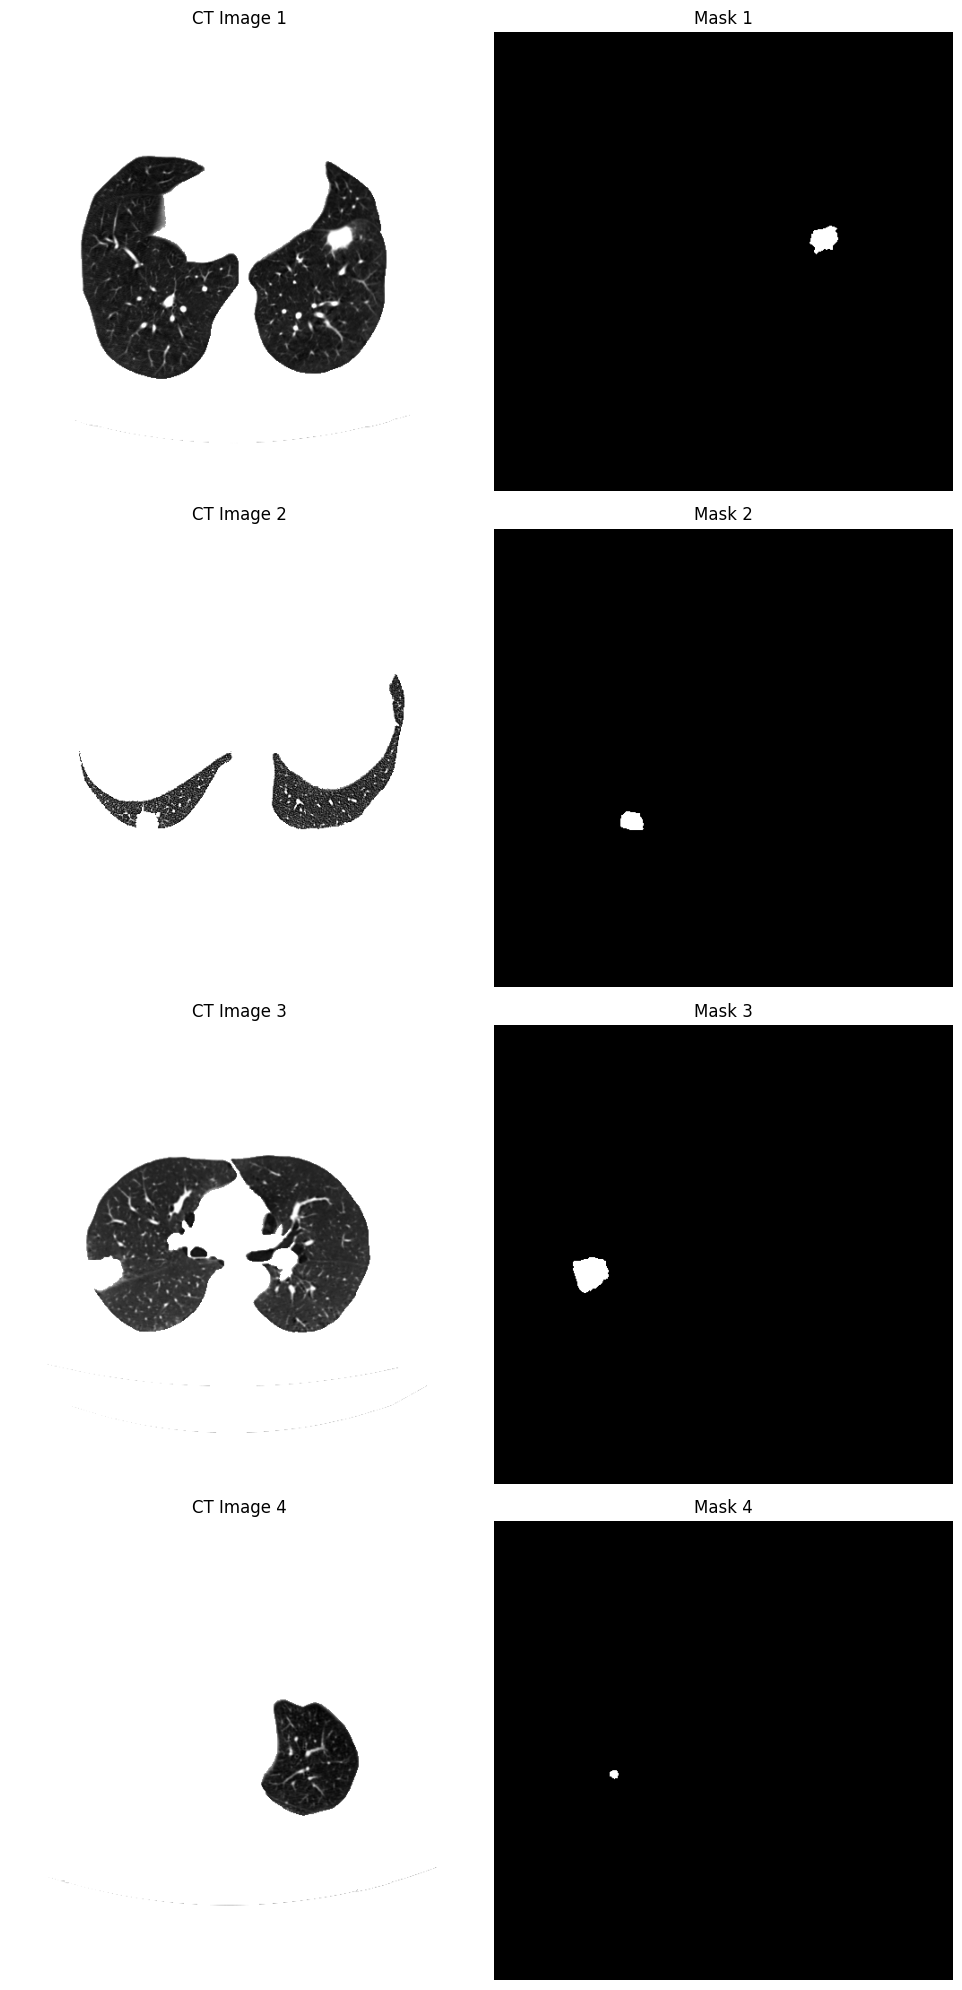

In [14]:
def plot_samples(imgs, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        img = imgs[i].squeeze().cpu().numpy()  # Remove batch dimension
        mask = masks[i].squeeze().cpu().numpy()

        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'CT Image {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize a batch (max. 4)
for img, mask in train_loader:
    plot_samples(img, mask, num_samples=min(4, img.shape[0]))
    break